# Tarea 6 - Modelos de IA
En esta tarea implementaréis un generador de texto basado en un GPT en miniatura. Así veremos cómo es el código de un transformer como el descrito en los apuntes.

Tomaréis como base el ejemplo https://keras.io/examples/generative/text_generation_with_miniature_gpt/, y entregaréis vuestro cuaderno de Colab (URL o documento, como prefiráis) con las explicaciones y modificaciones que se solicitan a continuación.

Realizad los siguientes pasos y responded a las cuestiones planteadas aquí dentro de recuadros de texto en vuestro cuaderno de Colab.

## 1. Setup.
Lo primero que haré es plasmar el código de *keras.ia*

In [1]:
# En caso de no tener keras instalado usamos el siguiente código para instalarlo
# pip install keras

# instalar la última versión
# pip install keras --upgrade

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization
import numpy as np
import os
import string
import random
import tensorflow
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

## 2. Implementación de un bloque transformer como capa. ¿Qué significa que la máscara de atención sea causal?

In [2]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = ops.arange(n_dest)[:, None]
    j = ops.arange(n_src)
    m = i >= j - n_src + n_dest
    mask = ops.cast(m, dtype)
    mask = ops.reshape(mask, [1, n_dest, n_src])
    mult = ops.concatenate(
        [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])], 0
    )
    return ops.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, "bool")
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

La máscara de atención causal se usa en los modelos de generación de texto para evitar que un token vea palabras futuras mientras se está generando la secuencia de texto. Esto impide que el modelo haga trampas y que solo utilice el contexto de palabras anteriores. Se implementa usando una matriz de máscara triangular, en la que se bloquean las posiciones futuras para cada token.

## 3. Implementación de las capas de embedding.

In [3]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(0, maxlen, 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## 4. Implementación del GPT en miniatura. ¿Qué funciones implementadas en los puntos anteriores se invocan ahora?

In [4]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 80  # Max sequence size
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer


def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype="int32")
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam",
        loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

Se está invocando la función "TokenAndPositionEmbedding()" que se encarga de pasar los tokens (palabras) a vectores y posicionarlos.

Además está también la función "TransformerBlock()" que usa una máscara causal para garantizar que cada palabra solo use información de las anteriores para generar las siguientes.

## 5. Datos para el modelo de lenguaje a nivel de palabra. ¿Cuál es la aplicación habitual del dataset IMDB?

In [5]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  8319k      0  0:00:09  0:00:09 --:--:-- 7846k


In [6]:
batch_size = 128

# The dataset contains each review in a separate text file
# The text files are present in four different folders
# Create a list all files
filenames = []
directories = [
    "aclImdb/train/pos",
    "aclImdb/train/neg",
    "aclImdb/test/pos",
    "aclImdb/test/neg",
]
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f))

print(f"{len(filenames)} files")

# Create a dataset from text files
random.shuffle(filenames)
text_ds = tf_data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)


def custom_standardization(input_string):
    """Remove html line-break tags and handle punctuation"""
    lowercased = tf_strings.lower(input_string)
    stripped_html = tf_strings.regex_replace(lowercased, "<br />", " ")
    return tf_strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices


def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tensorflow.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


text_ds = text_ds.map(prepare_lm_inputs_labels, num_parallel_calls=tf_data.AUTOTUNE)
text_ds = text_ds.prefetch(tf_data.AUTOTUNE)

50000 files


El dataset IMDB se usa habitualmente para el análisis de sentimientos en textos, específicamente en reseñas de películas. Se usa para entrenar modelos de lenguaje que clasifiquen opiniones como positivas o negativas.

## 6. Implementación del callback Keras para generar texto. ¿Qué cambio haríais en el código para que siempre elija la palabra más probable?

In [7]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    ###   MODIFICACION  ###
    def sample_from(self, logits):
        return np.argmax(logits)

        # logits, indices = ops.top_k(logits, k=self.k, sorted=True)
        # indices = np.asarray(indices).astype("int32")
        # preds = keras.activations.softmax(ops.expand_dims(logits, 0))[0]
        # preds = np.asarray(preds).astype("float32")
        # return np.random.choice(indices, p=preds)
    ###                  ###

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x, verbose=0)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")


# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

He cambiado la función "sample_from" que retornaba un valor aleatorio. Ahora retorna np.argmax(logits), lo que se traduce en devolver el índice del valor más grande de *logits*, de esta manera conseguimos la palabra más probable siempre.

## 7. Entrenad el modelo con otro dataset de texto de un tamaño suficiente.

In [8]:
# model = create_model()

# model.fit(text_ds, verbose=2, epochs=25, callbacks=[text_gen_callback])

## 8. Cambiad el código de generación de texto de manera que, en lugar de detenerse al generar un número de tokens, se detenga cuando genere un punto. De esta forma, las frases generadas siempre serán completas.

In [9]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        return np.argmax(logits)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x, verbose=0)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)

            # Detiene la generación de texto si el token es un punto.
            if self.detokenize(sample_token) == ".":
                break

        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")


# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

In [10]:
model = create_model()

model.fit(text_ds, verbose=2, epochs=5, callbacks=[text_gen_callback])

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


generated text:
this movie is a good movie .

391/391 - 4773s - 12s/step - loss: 5.4672
Epoch 2/5
generated text:
this movie is a very good movie .

391/391 - 4744s - 12s/step - loss: 4.7013
Epoch 3/5
generated text:
this movie is a very good movie .

391/391 - 4664s - 12s/step - loss: 4.4531
Epoch 4/5
generated text:
this movie is a very good movie .

391/391 - 4619s - 12s/step - loss: 4.2970
Epoch 5/5
generated text:
this movie is a very good movie .

391/391 - 4614s - 12s/step - loss: 4.1779


# Chatbots basados en LLM

## 9. Comparau el rànquing de xatbots disponible a lmarena.ai amb el dels apunts. Quines diferències hi destacau?

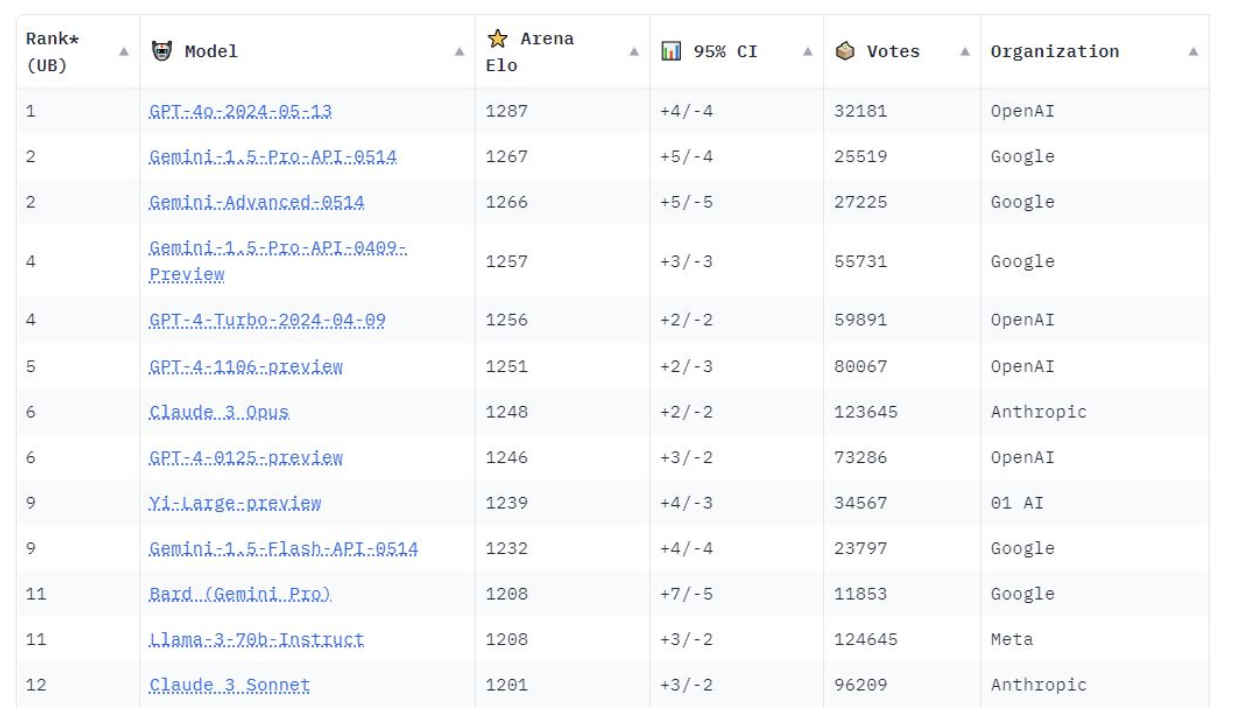

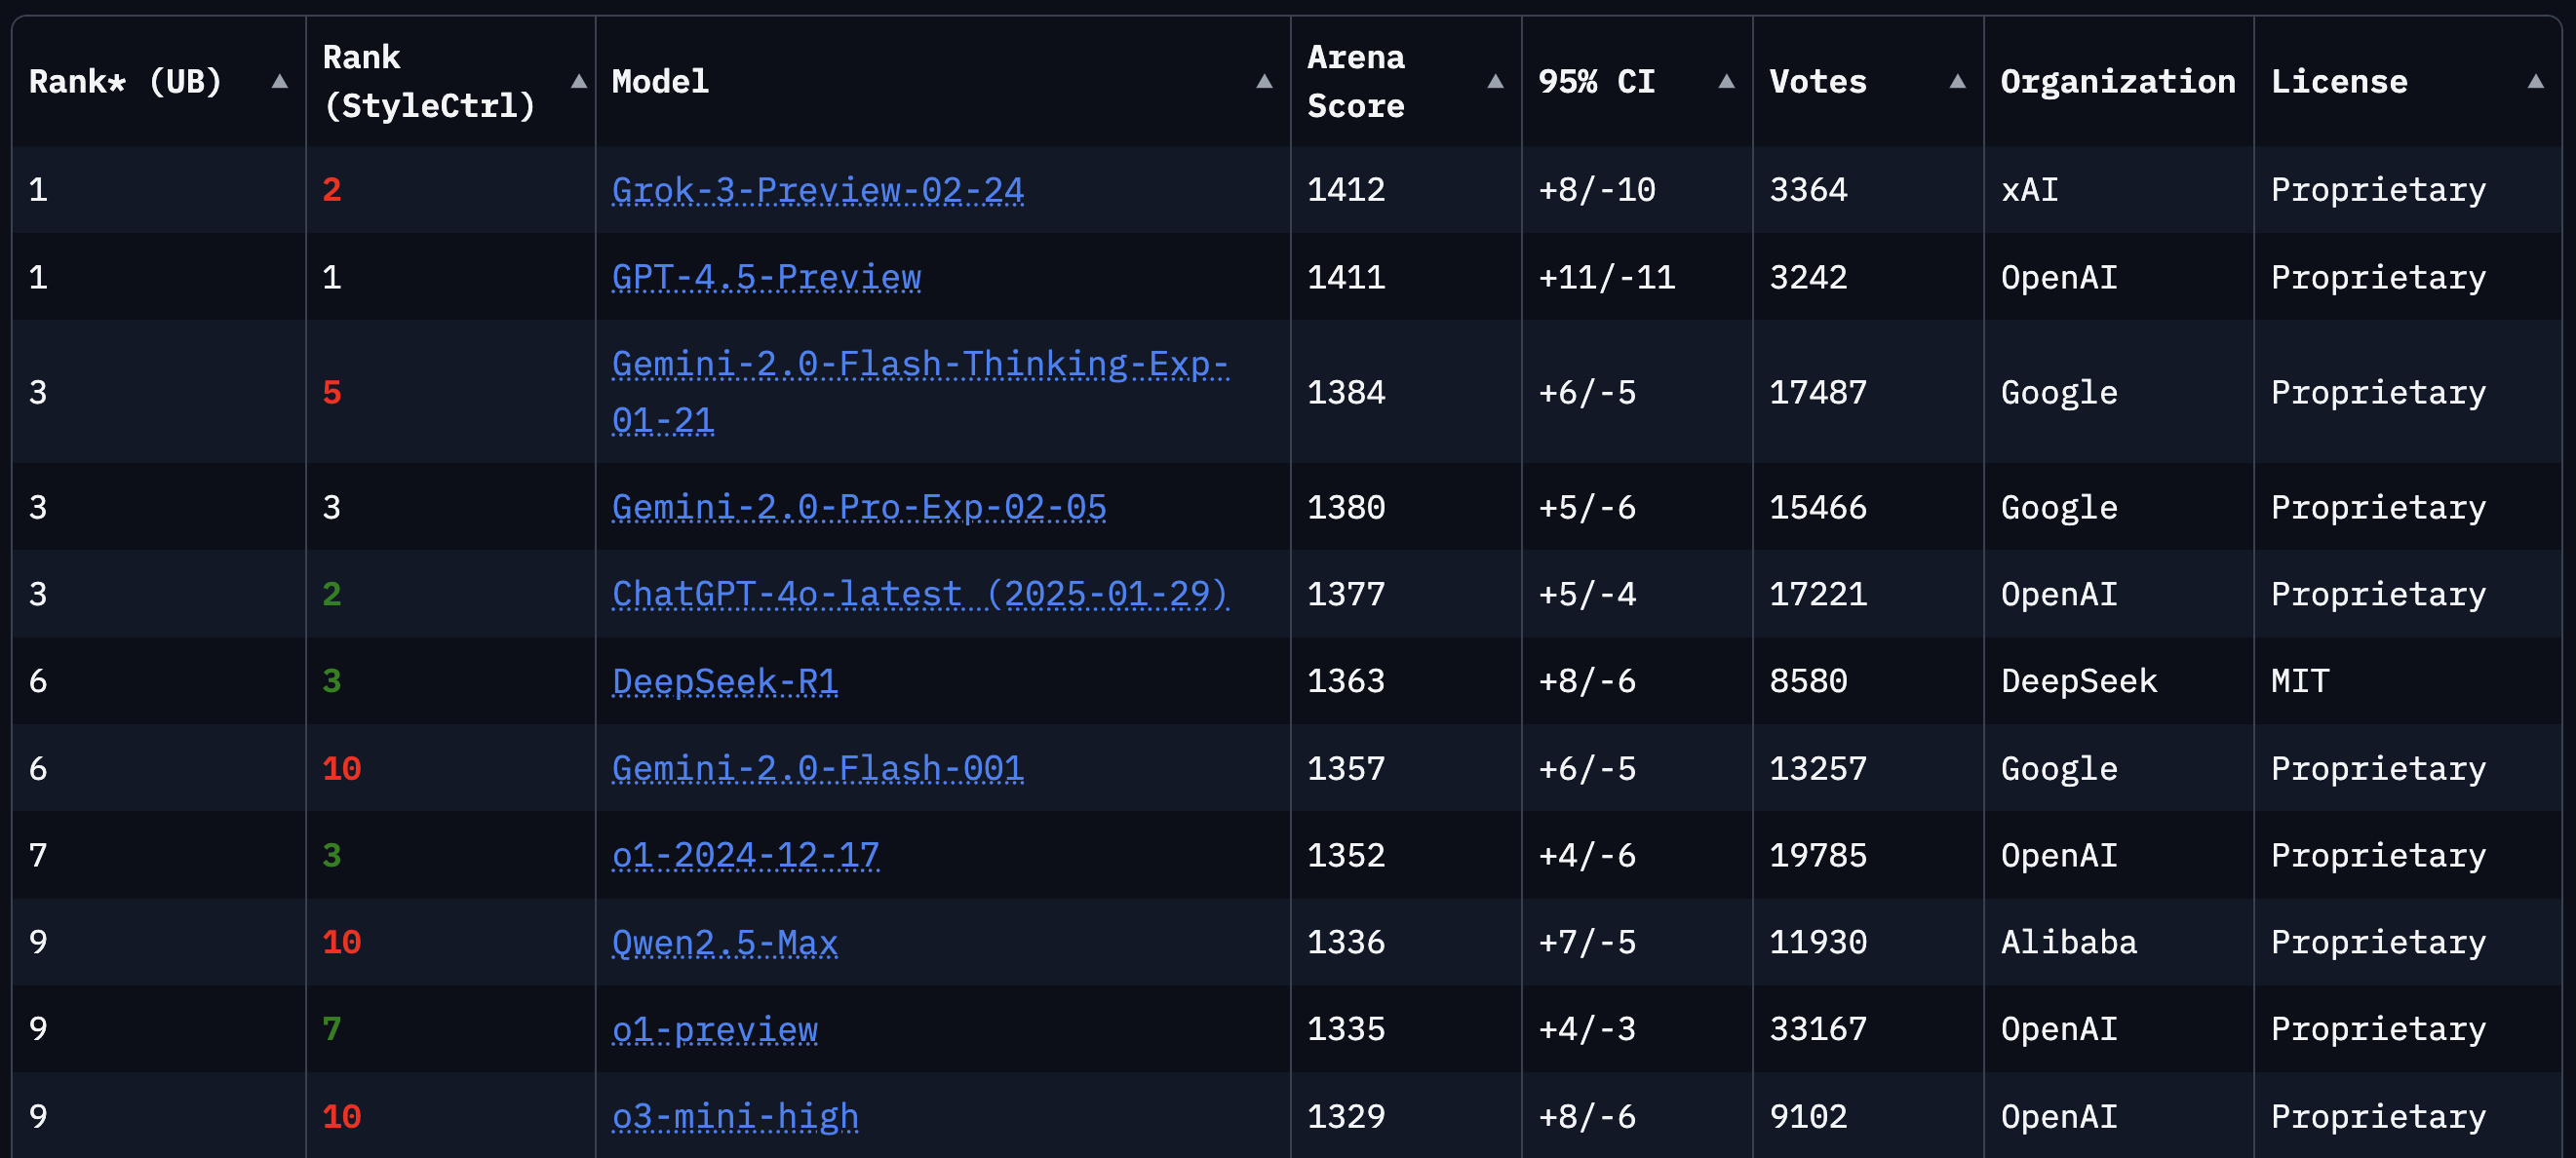

Comparando los dos rankings, uno de junio de 2024 y otro de marzo de 2025, podemos ver claramente cómo la inteligencia artificial es un sector en constante evolución.

Ahora mismo, Grok 3 preview y GPT-4.5 preview están liderando la tabla. Grok, el modelo de Elon Musk, parece haber causado buena impresión, y GPT-4.5, aunque salió hace apenas unos días, ya está bien posicionado. Aun así, no ha sido ninguna revolución como lo fueron otros GPT anteriores.

En cambio, en la lista de junio de 2024, GPT-4o era el que estaba en lo más alto, ya que en su momento era lo más potente de OpenAI. Ahora ha desaparecido del ranking, al igual que Claude 3 Opus, lo cual es curioso.

Luego está el caso de Gemini y Deepseek. Gemini 1.5 ha sido sustituido en su puesto del ranking por Gemini 2.0. Esto es positivo para Gemini ya que si lo comparamos con algunos modelos de OpenAI como GPT-4 o GPT-4 Turbo, ha aguantado bastante bien. Deepseek-R1, por su parte, está en sexta posición, lo cual llama la atención porque tuvo mucho bombo en su lanzamiento.

Supongo que esto se debe a varias cosas. Primero, la llegada de Grok y GPT-4.5 ha cambiado el panorama. Segundo, el hecho de que Deepseek venga de China y tenga un precio tan bajo puede haber generado dudas con el tiempo. Quizás la gente se esté preguntando si sus datos estarán realmente seguros o si pueden acabar en manos del gobierno chino, pero bueno, esto es solo una teoría.

## 10. Provau alguns LLM que hi ha disponibles a través de la interfície de xat de HuggingFace i comentau les diferències que hi heu observat. Hi ha models recents com DeepSeek 3 i Grok 3?

Al probar algunos de los modelos disponibles en la interfaz de chat de HuggingFace, he notado algunas diferencias interesantes.

Modelos como DeepSeek V3 y Grok 3, a pesar de ser de los más novedosos, muestran avances interesantes en cuanto a rapidez y precisión. Grok 3 parece estar centrado en generar respuestas más naturales y fluidas, mientras que DeepSeek V3 tiene una gran capacidad para manejar unos prompts más complejos.

También he probado por otro lado modelos más concidos como GPT-4 y Gemini. Estos modelos, aunque siguen siendo muy potentes, no muestran avances tan grandes en cuanto a velocidad o fluidez comparado con Grok 3 o DeepSeek V3. Sin embargo, siguen siendo importantes por su capacidad de generar buenas respuestas coherentes y bien estructuradas en muchos de contextos distintos.